In [14]:
# Remove conflicting packages from the base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai

# Install langgraph and the packages needed.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

In [16]:
# Imports
import os
import json
import re

from google import genai
from google.genai import types

from pprint import pprint
from random import randint
from typing import List, Dict, Any, Annotated, Literal, Optional
from collections.abc import Iterable
from typing_extensions import TypedDict
from IPython.display import Image, display

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.messages.tool import ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI

In [113]:
# Setup API key for Gemini
os.environ["GOOGLE_API_KEY"] = "remembered-this-time-too"

In [114]:
class PCBuilderState(TypedDict):
    """State representing the PC builder conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # User requirements
    # requirements: Dict[str, Any]
    requirements: list[str]

    # Budget information
    budget: str

    # Current recommendations for parts
    recommendations: list[Dict[str, Any]]

    # Flag for whether the build is complete
    build_complete: bool

    # Flag to indicate waiting for user input
    # waiting_for_user: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
PC_BUILDER_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    """
You are a PC Builder Assistant, an expert in computer hardware and building custom PCs.
Your goal is to help users find the perfect PC build based on their budget and requirements.

You should:
1. Ask about their budget and use case (gaming, office work, content creation, etc.)
2. Determine if they need a custom build or pre-built system.
3. For pre-built systems, ask if desktops or laptops or either are preferred.
4. For custom builds, if they have existing hardware, ask what parts they want to upgrade.

Once you have a general idea of what the user is looking for, you must formulate that
into a structured list of concise individual requirements and call the update_plans tool,
providing the budget and list of requirements. For custom build devices, if the user
mentions wanting the PC for a specific task that is hardware intensive, such as playing a
video game or video editing or training AI models or such, then first use the
search_task_requirements tool to find the hardware requirements for the specified task,
and only then update the user requirements using the update_plans tool, with the extra
hardware requirements added to it.

For pre-builds, even if there are potentially-intensive task requirements, you can call
the update_plans tool directly, adding the task requirements as part of the main requirements.

Once the requirements are all logged by the tool, summarize the requirements back to the
user in a couple of sentences using the latest requirements list and budget returned by
your last call of the tool.

If the user wants to change something in their plans, send a new list of requirements back
to update_plans. If they want to start from scratch, use the clear_plan tool to remove all
budget and requirements, then walk through the requirements gathering steps again.

If the user confirms their requirements are final and they want a pre-built device, use
search_prebuilt tool to find pre-built devices fitting the user criteria, which will be
given to you in a structured JSON format. If the JSON has formatting errors and you cannot
understand it, recall the search_prebuilt tool. If the JSON can be understood, call the
rank_prebuilds tool and provide it the exact same JSON (it will not work without JSON!) to
get a final list of recommendations and then render this neatly in markdown for the user
to browse.

If the user confirms their requirements are final and they want a custom build, use the
lookup_parts_needed tool to get a list of the parts required. Once you have the parts,
call the search_custom_parts tool to get a list of parts, which should be in a structured
JSON format. If the JSON has formatting errors and you cannot understand it, recall the
search_custom_parts tool. If the JSON can be understood, call the rank_parts tool and
provide it the exact same JSON (it will not work without JSON!) to get a final list of
parts for the user. Render this neatly in markdown for the user to browse.

The user may have additional questions about the parts or building process, which you must
expand upon if asked.

If any of the tools are unavailable, let the user know instead of trying to call the tools.

Stay focused on PC building. If users ask about unrelated topics, gently redirect them.
""",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the PC Builder Assistant! (Type `q` to quit). I'll help you find the perfect computer based on your needs and budget. Could you tell me your budget and what you'll be using this PC for? (Gaming, office work, content creation, etc.)"

In [115]:
# LLM model definitions
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
client = genai.Client(api_key=os.environ["GOOGLE_API_KEY"])
MAIN_MODEL = 'gemini-2.0-flash'

In [116]:
# Stateless tool - Search online for pre-built devices

@tool
def search_prebuilt(budget: str, requirements: list[str]) -> str:
    '''Search for pre-built desktops or laptops fulfilling the user criteria.
    Take the budget and requirements, and get Gemini to format it into a terse, concise query.
    Then use search grounding to look for it and return the output as structured JSON with
    price, brand, desktop/laptop, name, link to view more or buy
    '''
    print('CALLED TOOL: search_prebuilt')

    USE_LANGGRAPH_SEARCH = False  # Will use Gemini search if false, both techniques seem to hallucinate info
    newline_char = '\n'

    search_config = types.GenerateContentConfig(
        tools=[types.Tool(google_search=types.GoogleSearch())],
        temperature=0.0
    )

    prompt = f'''
You are a computer hardware specialist who always responds in valid JSON. Search online
for pre-built laptops or desktops based on the requirements provided below and return
the results in JSON format with name, price, specifications, and purchase link for each
device. Find at least 3-6 options for the device in question.

JSON Structure to follow:
Return a list of device objects, where each object has three fields: name, price, and specifications.

Key points to note:
- Please answer the following question using ONLY information found in the provided web search results. Cite your sources for each statement or paragraph.
- Rely exclusively on the real-time search results to answer. For each device in the JSON list you make, indicate which search result supports it.

Device Requirements:
    1. Budget: {budget}
    2. Requirements: {newline_char + (newline_char.join([((' ' * 8) + '- ' + req) for req in requirements]))}
'''

    response = None

    if USE_LANGGRAPH_SEARCH:
        search_model = ChatGoogleGenerativeAI(
            model=MAIN_MODEL,
            config=search_config,
            # convert_system_message_to_human=True  # Handle system messages properly
        )
        response = search_model.invoke([
            HumanMessage(content=prompt)
        ])
        return response.content
    else:
        response = client.models.generate_content(
            model=MAIN_MODEL,
            contents=prompt,
            config=search_config
        )
        rc = response.candidates[0]
        return rc.content.parts[0].text

In [117]:
# Stateless tool - Search hardware requirements for a particular task
@tool
def search_task_requirements():
    '''
    '''
    print('CALLED TOOL: search_task_requirements')

In [118]:
# Stateless tool - Lookup parts required internally using RAG and rules of thumb
@tool
def lookup_parts_needed():
    '''
    '''
    print('CALLED TOOL: lookup_parts_needed')
'''
4. For custom builds, recommend parts following these rules:
   - GPU: ~50% of total budget
   - CPU: Should not bottleneck the GPU
   - Motherboard: Quality based on other components
   - RAM: Compatible with CPU/motherboard overclocking specs
   - PSU: At least 10% headroom over expected power draw, 20-30% for future upgrades
   - Storage: Prioritize SSDs for budget builds, M.2 for pro builds, HDDs only if necessary
   - Cooler: Appropriate for the CPU (no air cooling for hot CPUs)
   - Case: Compatible with GPU length, motherboard type, and storage needs
   - Fans: Minimum 3 fans (2 intake, 1 exhaust)
'''

'\n4. For custom builds, recommend parts following these rules:\n   - GPU: ~50% of total budget\n   - CPU: Should not bottleneck the GPU\n   - Motherboard: Quality based on other components\n   - RAM: Compatible with CPU/motherboard overclocking specs\n   - PSU: At least 10% headroom over expected power draw, 20-30% for future upgrades\n   - Storage: Prioritize SSDs for budget builds, M.2 for pro builds, HDDs only if necessary\n   - Cooler: Appropriate for the CPU (no air cooling for hot CPUs)\n   - Case: Compatible with GPU length, motherboard type, and storage needs\n   - Fans: Minimum 3 fans (2 intake, 1 exhaust)\n'

In [119]:
# All stateless tools, part of tools node: Search game specs, lookup parts needed (sends to
# chatbot which then sends to search part then back to chatbot which then updates
# recommendations; must also take in existing hardware), search custom part (searches
# each part mentioned by lookup parts, takes in list of strs from chatbot or directly
# from lookup, does google search or external api call,  returns json for each part) ->
# this then goes to optimize build and then gets put in recommendations.

In [120]:
# Stateless tool - Search online for custom parts for the build
@tool
def search_custom_parts():
    '''
    '''
    print('CALLED TOOL: search_custom_parts')

In [121]:
# Tool signatures for planning the build
# Functionality defined in pc_planner_node
@tool
def update_plans(requirements: Iterable[str], budget: Optional[str] = None) -> Dict[str, Any]:
    '''
    Adds or modifies the device requirements and budget.
    Returns a confirmation of the budget and requirements that were just added to state.
    '''


@tool
def clear_plan():
    '''
    Removes all requirements and budget information and resets to blank slate.
    '''

In [122]:
# Tool signatures for recommending parts for a planned build
# Functionality defined in optimize_build_node
@tool
def rank_parts():
    '''
    Takes in a list of parts in JSON and a budget and returns the most
    performant yet price-optimal parts for each part.
    Modifies state by adding the parts to the recommendations list.
    '''


@tool
def rank_prebuilds(recommended_devices: str = '') -> str:
    '''
    Takes in a list of prebuilt devices in JSON and a budget and returns the top
    three most performant yet price-optimal devices, also in JSON.
    Modifies state by adding the devices to the recommendations list.
    '''

In [123]:
# Helper functions required to rank pre-built devices

def parse_price(price_str: str) -> float:
    '''Extract numeric price value from the provided string.'''
    # Extract digits and decimal value
    price_match = re.search(r'[\d,.]+', price_str)
    if not price_match:
        return 0.0

    # Remove commas and convert to float
    price_digits = price_match.group(0).replace(',', '')
    return float(price_digits)


def score_specs(specs: str) -> int:
    """
    Analyze specifications to score device performance.
    Higher scores indicate better performance.
    """
    score = 0
    specs = specs.lower()

    # CPU scoring
    if 'ryzen 7' in specs or 'i7' in specs:
        score += 80
    elif 'ryzen 5' in specs or 'i5' in specs:
        score += 60
    elif 'ryzen 3' in specs or 'i3' in specs:
        score += 40

    # Generation bonus
    if '5700' in specs:
        score += 20
    elif '5600' in specs or '5500' in specs:
        score += 15
    elif '4500' in specs or '4600' in specs:
        score += 10

    # RAM scoring
    ram_match = re.search(r'(\d+)gb', specs.replace(' ', ''))
    if ram_match:
        ram_size = int(ram_match.group(1))
        if ram_size >= 32:
            score += 50
        elif ram_size >= 16:
            score += 30
        elif ram_size >= 8:
            score += 15

    # Storage scoring
    if '1tb' in specs.replace(' ', ''):
        score += 30
    elif '500gb' in specs.replace(' ', '') or '512gb' in specs.replace(' ', ''):
        score += 20

    if 'nvme' in specs or 'ssd' in specs:
        score += 20

    # GPU scoring
    if 'rtx 3080' in specs:
        score += 100
    elif 'rtx 3070' in specs:
        score += 80
    elif 'rtx 3060' in specs:
        score += 70
    elif 'gtx 1650' in specs:
        score += 40
    elif 'radeon' in specs or 'onboard' in specs:
        score += 20

    return score


def get_value_ratio(device: Dict[str, Any], budget: float) -> float:
    """
    Calculate value ratio based on specs score and price.
    Returns 0 if device exceeds budget.
    """
    price = parse_price(device['price'])
    if price > budget:
        return 0

    specs_score = score_specs(device['specifications'])

    # Calculate value ratio (specs score per unit of price)
    # Higher ratio means better value
    if price > 0:
        return specs_score / price
    return 0


def rank_devices(devices_json: str, budget: float, return_json: Optional[bool] = False) -> Any:
    '''
    Rank devices based on specifications and price within budget.
    Returns JSON string with top 3 devices.
    '''
    devices = json.loads(devices_json)
    if isinstance(devices, dict):
        devices = devices['devices']

    for device in devices:
        device['value_ratio'] = get_value_ratio(device, budget)

    # Sort devices by assigned value ratios descending
    ranked_devices = sorted(devices, key=lambda x: x['value_ratio'], reverse=True)

    # Select top 3 within budget
    top_devices = [
        {k: v for k, v in device.items() if k != 'value_ratio'}
        for device in ranked_devices[:3] if parse_price(device['price']) <= budget
    ]

    if return_json:
        return json.dumps(top_devices, indent=4, ensure_ascii=False)
    return top_devices

In [124]:
# Tool grouped on nodes
planner_tools = [update_plans, clear_plan]
builder_tools = [rank_parts, rank_prebuilds]

In [125]:
# Tools Config
auto_tools = [search_prebuilt, search_task_requirements, lookup_parts_needed, search_custom_parts]
tool_node = ToolNode(auto_tools)

# Tool binding
llm_with_tools = llm.bind_tools(auto_tools + planner_tools + builder_tools)

In [126]:
# Build planner node
def pc_planner_node(state: PCBuilderState) -> PCBuilderState:
    '''This is where the requirements and budget within state get manipulated.'''

    tool_msg = state.get("messages", [])[-1]
    requirements_state = state.get("requirements", [])
    budget_state = state.get('budget', None)
    recommendations_state = state.get('recommendations', [])
    outbound_msgs = []
    build_complete = state.get('build_complete', False)

    for tool_call in tool_msg.tool_calls:
        if tool_call['name'] == 'update_plans':
            print('CALLED TOOL: update_plans')
            args_given = tool_call['args']
            requirements_arg = budget_arg = None
            if 'requirements' in args_given:
                requirements_arg = args_given['requirements']
            if 'budget' in args_given:
                budget_arg = args_given['budget']
            # If budget is None and nothing exists in state, raise an error.
            # If there is something in state, then just don't update it.
            # Otherwise always update the budget.
            if budget_arg is None or len(budget_arg) < 1:
                if budget_state is None or len(budget_state) < 1:
                    raise ValueError(f'Budget is missing in tool call as well as state!')
            else:
                budget_state = budget_arg
            if requirements_arg is None or len(requirements_arg) < 1:
                if requirements_state is None or len(requirements_state) < 1:
                    raise ValueError('Requirements are missing in tool call as well as state!')
            else:
                requirements_state = [requirement for requirement in requirements_arg]
            response = {
                'budget': budget_arg if budget_arg is not None else budget_state,
                'requirements': requirements_arg
            }

        elif tool_call['name'] == 'clear_plan':
            print('CALLED TOOL: clear_plan')
            requirements_state = []
            budget_state = None
            response = None

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {
        "messages": outbound_msgs,
        "requirements": requirements_state,
        'budget': budget_state,
        'recommendations': recommendations_state,
        "build_complete": build_complete
    }

In [127]:
# Parts recommender node (based on devised plan and recommended devices)
def optimize_build_node(state: PCBuilderState) -> PCBuilderState:
    '''This is where the recommendations within state get manipulated.'''
    # state.recommendations modified by tool rank_parts() part of optimize_build node
    # - happens once search_prebuilt() tool returns a few values

    tool_msg = state.get("messages", [])[-1]
    requirements_state = state.get("requirements", [])
    budget_state = state.get('budget', None)
    recommendations_state = state.get('recommendations', [])
    outbound_msgs = []
    build_complete = state.get('build_complete', False)

    for tool_call in tool_msg.tool_calls:
        if tool_call['name'] == 'rank_parts':
            print('CALLED TOOL: rank_parts')
            pass

        elif tool_call['name'] == 'rank_prebuilds':
            print('CALLED TOOL: rank_prebuilds')
            recommended_devices = tool_call['args']['recommended_devices']
            if budget_state is None or len(budget_state) < 1:
                raise ValueError(f'An invalid budget of NoneType was found!')
            print('\nThis is the recommendations json provided:\n', recommended_devices, '\n')
            recommendations_state = rank_devices(recommended_devices, parse_price(budget_state))
            response = rank_devices(recommended_devices, parse_price(budget_state), True)

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {
        "messages": outbound_msgs,
        "requirements": requirements_state,
        'budget': budget_state,
        'recommendations': recommendations_state,
        "build_complete": build_complete
    }

In [128]:
def chatbot_node(state: PCBuilderState) -> PCBuilderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    default_state = {'requirements': [], 'budget': None, 'recommendations': [], 'build_complete': False}

    if state['messages']:
        # If there are messages, continue the conversation with the model
        message_history = [PC_BUILDER_SYSINT] + state["messages"]
        new_output = llm_with_tools.invoke(message_history)
    else:
        # If there are no messages, welcome the user.
        new_output = AIMessage(content=WELCOME_MSG)

    # Setup some defaults, then override with whatever exists in state, and finally
    # override with messages
    return default_state | state | {"messages": [new_output]}

In [129]:
def human_node(state: PCBuilderState) -> PCBuilderState:
    """Display the last message from the model to the user, and receive their input."""

    print('\nAll state until now:')
    for key, val in state.items():
        print(key, '::', val)
        print('\n')
    print('\nNow onto the messages:\n')

    last_msg = state['messages'][-1]
    print('Model:', last_msg.content)

    user_input = input('User: ')

    # Does the user wish to quit?
    if user_input in {'q', 'quit', 'exit', 'goodbye'}:
        state['build_complete'] = True

    return state | {'messages': [('user', user_input)]}

In [130]:
# Human to Exit OR Human to Chatbot; Conditional Edge Transition function
def maybe_exit_human_node(state: PCBuilderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("build_complete", False):
        return END
    else:
        return "chatbot"

In [131]:
# Chatbot to Tools OR Chatbot to Human; Conditional Edge Transition function
def maybe_route_to_tools(state: PCBuilderState) -> str:
    if not (msgs := state.get('messages', [])):
        raise ValueError(f'No messages found when parsing state: {state}')

    # Only route based on the last message.
    msg = msgs[-1]

    if state.get('build_complete', False):
        # If the user has no more questions or indicates satisfaction, complete the build
        return END
    elif hasattr(msg, 'tool_calls') and len(msg.tool_calls) > 0:
        # When chatbot returns tool_calls, route to the 'tools' node
        if any(tool['name'] in tool_node.tools_by_name.keys() for tool in msg.tool_calls):
            return 'tools'
        elif any(tool['name'] in [func.name for func in planner_tools] for tool in msg.tool_calls):
            return 'pc_planner'
        elif any(tool['name'] in [func.name for func in builder_tools] for tool in msg.tool_calls):
            return 'optimize_build'
        else:
            raise ValueError('A nonexistent node was called.')
    else:
        return 'human'

In [132]:
# Set up the initial graph based on our state definition.
graph_builder = StateGraph(PCBuilderState)

# Add all the nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("pc_planner", pc_planner_node)
graph_builder.add_node("optimize_build", optimize_build_node)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

# Edge transitions
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
graph_builder.add_conditional_edges("human", maybe_exit_human_node)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("pc_planner", "chatbot")
graph_builder.add_edge("optimize_build", "chatbot")

chat_graph = graph_builder.compile()

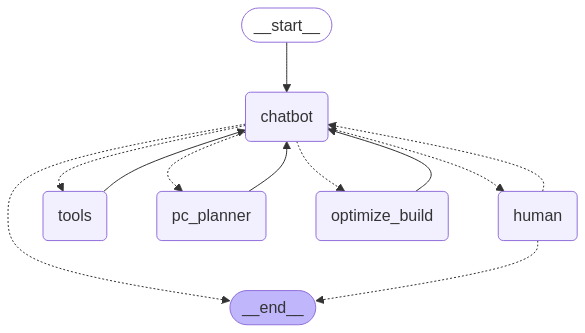

In [133]:
# Visualize the graph created.
Image(chat_graph.get_graph().draw_mermaid_png())

In [134]:
# The default recursion limit for traversing nodes is 25 - setting it higher means
# you can try a more complex order with multiple steps and round-trips (and you
# can chat for longer!)
config = {"recursion_limit": 100}

# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
state = chat_graph.invoke({"messages": []}, config)

# Things to try:
#  - Just chat! There's no ordering or menu yet.
#  - 'q' to exit.

pprint(state)


All state until now:
messages :: [AIMessage(content="Welcome to the PC Builder Assistant! (Type `q` to quit). I'll help you find the perfect computer based on your needs and budget. Could you tell me your budget and what you'll be using this PC for? (Gaming, office work, content creation, etc.)", additional_kwargs={}, response_metadata={}, id='b7731379-f5f1-4627-b51d-48caed0731fa')]


requirements :: []


budget :: None


recommendations :: []


build_complete :: False



Now onto the messages:

Model: Welcome to the PC Builder Assistant! (Type `q` to quit). I'll help you find the perfect computer based on your needs and budget. Could you tell me your budget and what you'll be using this PC for? (Gaming, office work, content creation, etc.)
User: I want a gaming pc

All state until now:
messages :: [AIMessage(content="Welcome to the PC Builder Assistant! (Type `q` to quit). I'll help you find the perfect computer based on your needs and budget. Could you tell me your budget and what y